# Using simulated clinical and genomic data to build and evaluate a predictive model of one-year survival after diagnosis with NSCLC

## Background

Lung cancer is the leading cause of cancer-related deaths worldwide. In 2018, the United States is estimated to have had approximately 234,030 new diagnoses of lung cancer, with an estimated 154,050 deaths. As lung cancer is a highly heterogeneous disease with variable survival outcomes, there has been wide interest in developing prognostic models that integrate varying sources of patient information (e.g. demographic, clinical, genomic, imaging) to predict patient survival following diagnosis. An eventual goal for these models is to deploy them as part of decision support systems to facilitate improved decision making in routine clinical practice.

### Data Description

**File Name:** clinical.csv

**Description:** Contains clinical data on each patient. Its columns are as follows:
- **ID:** A unique identifier for the patient.
- **Outcome:** Whether the patient is alive or dead at the followup time.
- **Survival.months:** The followup time in months.
- **Age:** The patient’s age (in years) at diagnosis.
- **Primary Site:** Location of primary tumor.
- **Histology:** The tumor histology
- **Stage:** Stage at diagnosis.
- **Grade:** Tumor grade (1-4 or missing).
- **Num.Primaries:** Number of primary tumors.
- **Tumor.Size:** Size of the tumor at diagnosis.
- **T:** Tumor Stage.
- **N:** Number of metastasis to lymph nodes.
- **M:** Number of distant metastases.
- **Radiation:** Whether radiation took place (5) or not (0).
- **Num.Mutations:** The total number mutations found in the tumor.
- **Num.Mutated.Genes:** The total number of genes with mutation.

**File Name:** genomics.csv

**Description:** Contains information as to which genes were found to have mutation in
each patient’s tumor sequencing data. Only genes with mutation are listed. Its columns are as follows:

- **ID:** A unique identifier for the patient.
- **Gene:** The name of the gene.

## Imports

In [3895]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from turtle import title
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
import warnings

## Load the Data

In [3896]:
data_clinical_raw = pd.read_csv('Data/clinical.csv')
data_genomic_raw = pd.read_csv('Data/genomics.csv')
df_data_clinical_raw = pd.DataFrame(data_clinical_raw)
df_data_genomic_raw = pd.DataFrame(data_genomic_raw)

## Initial Data Exploration

### Clinical Data

In [3897]:
df_data_clinical_raw.head()

,ID,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
0,1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
1,2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
2,3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
3,4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
4,5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3


In [3898]:
df_data_clinical_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 190 non-null    int64  
 1   Outcome            190 non-null    object 
 2   Survival.Months    190 non-null    float64
 3   Age                190 non-null    int64  
 4   Grade              190 non-null    int64  
 5   Num.Primaries      190 non-null    int64  
 6   T                  190 non-null    object 
 7   N                  125 non-null    float64
 8   M                  94 non-null     float64
 9   Radiation          190 non-null    int64  
 10  Stage              190 non-null    object 
 11  Primary.Site       190 non-null    object 
 12  Histology          190 non-null    object 
 13  Tumor.Size         98 non-null     float64
 14  Num.Mutated.Genes  190 non-null    int64  
 15  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(7), o

In [3899]:
df_data_clinical_raw.describe()

,ID,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,190.000000,190.000000,125.000000,94.000000,190.000000,98.000000,190.000000,190.000000
mean,95.500000,22.186842,70.173684,6.105263,0.226316,1.144000,0.085106,1.657895,4.494898,2.684211,3.084211
std,54.992424,12.420140,6.146909,2.995495,0.419551,1.029438,0.280536,2.360122,3.050988,1.460327,1.697575
min,1.000000,9.000000,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.250000,11.000000,67.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,95.500000,16.000000,71.000000,9.000000,0.000000,2.000000,0.000000,0.000000,3.600000,3.000000,3.000000
75%,142.750000,34.000000,74.000000,9.000000,0.000000,2.000000,0.000000,5.000000,8.000000,3.000000,4.000000
max,190.000000,71.000000,84.000000,9.000000,1.000000,3.000000,1.000000,5.000000,10.000000,8.000000,8.000000


### Genomic Data

In [3900]:
df_data_genomic_raw.head()

,ID,Gene
0,1,AKT1
1,158,AKT1
2,88,ALK_Col1
3,132,ALK_Col1
4,18,ALK_Col2


In [3901]:
df_data_genomic_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      510 non-null    int64 
 1   Gene    510 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.1+ KB


In [3902]:
df_data_genomic_raw.describe()

,ID
count,510.000000
mean,93.962745
std,55.988602
min,1.000000
25%,47.000000
50%,94.000000
75%,144.000000
max,190.000000


## Data Cleansing

### Check for inconsistent data entry

The dataset may include spelling errors or other inconsistencies in data entry that may impact model accuracy. Using `groupby()` and `size()` can help identify such inconsistencies.

Columns **Outcome**, **T**, **Stage**, **Primary.Site**, and **Histology** contain data in string form, and thus are the most prone to inconsistent data entry and spelling errors. Let's check each of these columns.

No inconsistencies found in the **Outcome** column:

In [3903]:
print(df_data_clinical_raw.groupby('Outcome').size())

Outcome
Alive     40
Dead     150
dtype: int64


No inconsistencies found in the **T** column:

In [3904]:
df_data_clinical_raw.groupby('T').size()

T
1       1
1a     26
1b      2
2      12
2a     16
2b     10
3      38
4      23
UNK    62
dtype: int64

No inconsistencies found in the **Histology** column:

In [3905]:
df_data_clinical_raw.groupby('Histology').size()

Histology
Adenocarcinoma             86
Large-cell carcinoma       27
Squamous cell carcinoma    77
dtype: int64

In the **Stage** column, one row contains a misspelling "1B" which should be corrected to "IB":

In [3906]:
df_data_clinical_raw.groupby('Stage').size()

Stage
1B       1
IA      32
IB       1
IIA      8
IIB     11
IIIA    43
IIIB    24
IV      45
IVB     25
dtype: int64

In [3907]:
df_data_clinical_raw['Stage'] = df_data_clinical_raw['Stage'].replace(['1B'], 'IB')

In the **Primary.Site** column, two rows contain a misspelling "Righ Upper Lobe" which should be corrected to "Right Upper Lobe":

In [3908]:
df_data_clinical_raw.groupby('Primary.Site').size()

Primary.Site
Both Lung             5
Left Hilar           31
Left Lower Lobe      17
Left Upper Lobe      21
Righ Upper Lobe       2
Right Hilar          33
Right Lower Lobe     25
Right Middle Lobe     3
Right Upper Lobe     53
dtype: int64

In [3909]:
df_data_clinical_raw['Primary.Site'] = df_data_clinical_raw['Primary.Site'].replace(['Righ Upper Lobe'], 'Right Upper Lobe')

There are also some discrepencies in the **Grade** column, as the tumor grade should be a value of 1-4 or unspecified, yet some rows contain a value of 9. The fact that there are 96 rows with **Grade** values of 9 suggests significant data entry inconsistencies, and thus it is best to drop the entire column.

In [3910]:
df_data_clinical_raw.groupby('Grade').size()

Grade
2    29
3    22
4    43
9    96
dtype: int64

In [3911]:
df_data_clinical_raw = df_data_clinical_raw.drop(columns=['Grade'])

There are no unexpected values in the **Radiation** column:

In [3912]:
df_data_clinical_raw.groupby('Radiation').size()

Radiation
0    127
5     63
dtype: int64

### Check for missing data

In [3913]:
df_data_clinical_raw.isnull().any()

ID                   False
Outcome              False
Survival.Months      False
Age                  False
Num.Primaries        False
T                    False
N                     True
M                     True
Radiation            False
Stage                False
Primary.Site         False
Histology            False
Tumor.Size            True
Num.Mutated.Genes    False
Num.Mutations        False
dtype: bool

In [3914]:
print('"N" column value counts: \n', df_data_clinical_raw['N'].value_counts(dropna=False))

"N" column value counts: 
 NaN    65
2.0    58
0.0    52
1.0     9
3.0     6
Name: N, dtype: int64


In [3915]:
print('"M" column value counts: \n', df_data_clinical_raw['M'].value_counts(dropna=False))

"M" column value counts: 
 NaN    96
0.0    86
1.0     8
Name: M, dtype: int64


In [3916]:
print('"Tumor.Size" column value counts: \n', df_data_clinical_raw['Tumor.Size'].value_counts(dropna=False))

"Tumor.Size" column value counts: 
 NaN     92
2.0     20
1.5     13
9.0     10
3.6      9
10.0     8
4.0      7
5.5      6
8.5      6
3.5      2
5.4      2
5.3      2
2.5      2
1.4      2
8.0      2
1.8      2
1.9      2
4.4      1
1.6      1
1.0      1
Name: Tumor.Size, dtype: int64


Many rows are missing data for the columns **N**, **M**, and **Tumor.Size**. For example, more than half of the rows are missing data for **Tumor.Size**. However, tumor size is likely correlated with survival rate, and thus dropping the entire column is illogical. Similarly, the metastatic data described in columns **N** and **M** may be significant prognostic factors. Instead of dropping these columns or rows with null values, it makes more sense to fill the null values using imputation.

#### Imputation with SimpleImputer

In [3917]:
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_data_clinical_raw[['N', 'M', 'Tumor.Size']])
data_clinical_raw[['N', 'M', 'Tumor.Size']] = imputer.transform(data_clinical_raw[['N', 'M', 'Tumor.Size']])
df_data_clinical = data_clinical_raw   # cleaned dataset with imputed values
df_data_clinical = df_data_clinical.drop(columns=['Grade'])
df_data_clinical.head()

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
0,1,Alive,9.0,67,0,UNK,2.000,0.085106,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,8,8
1,2,Dead,19.0,73,0,UNK,2.000,0.000000,5,IV,Right Upper Lobe,Adenocarcinoma,4.494898,2,2
2,3,Dead,13.0,72,0,2,2.000,0.000000,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.500000,1,1
3,4,Dead,15.0,69,1,1a,0.000,1.000000,0,IA,Right Upper Lobe,Adenocarcinoma,4.494898,4,4
4,5,Dead,10.0,76,0,UNK,1.144,0.085106,0,IIIA,Left Hilar,Large-cell carcinoma,4.494898,3,3


## Exploratory Data Analysis

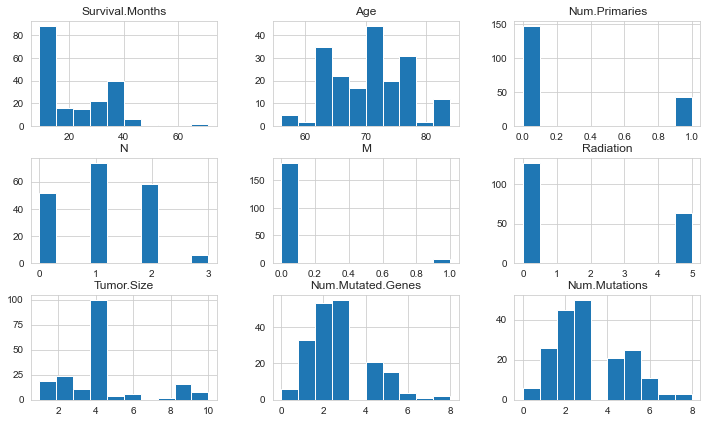

<Figure size 432x288 with 0 Axes>

In [3918]:
df_data_clinical_2.hist(layout= (5,3),figsize=(12,12))
plt.show()
plt.savefig('Figures/clinical_histograms.png')

A heatmap can be used to assess associations between prognostic factors and their influence on Survival Months.

In [3919]:
df_data_clinical_2 = df_data_clinical.drop(['ID'], axis=1)

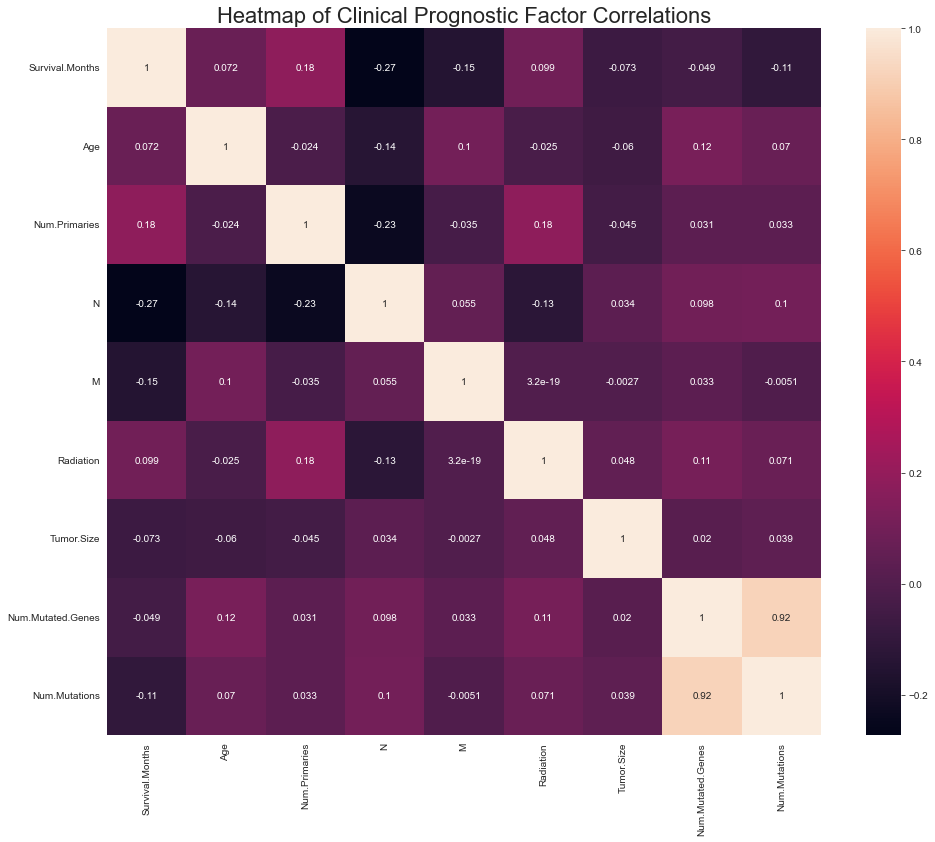

In [3920]:
plt.figure(figsize=(16, 13))
plt.title('Heatmap of Clinical Prognostic Factor Correlations', fontsize=22)
sns.heatmap(df_data_clinical_2.corr(), annot=True)
plt.savefig('Figures/clinical_heatmap.png')

**Highly correlated features:**
- Survival Months and Number of Primary Tumors
- Radiation and Number of Primary Tumors
- Number of Mutated Genes and Number of Mutations

**Some other potential correlations:**
- Age and number of distant metastases
- Age and Number of Mutated Genes
- Survival Months and Radiation
- Grade and Tumor Size

At first glance, these correlations suggest that number of primary tumors and radiation therapy may serve as some of the most influential prognostic factors in terms of clinical data. The TNM system is also of interest. Furthermore, it is logical to assume that tumor size, tumor stage, tumor location, and histological findings may have some bearing on prognosis. These factors, along with the genomic data, will be the focus of the exploratory data analysis.

### Number of Mutated Genes

#### A note on number of mutations:
Because the genomic data is derived from sequencing data, it is expected that some patients may have a greater number of mutations than mutated genes due to the presence of silent mutations. For this reason, only the **Num.Mutated.Genes** column along with the mutated genes themselves will be considered during analysis.

In [3921]:
df_data_clinical = df_data_clinical.drop(['Num.Mutations'], axis=1)

Most cancers are caused not by a single mutation but by a combination of mutations in multiple genes. For this reason, it is worth investigating whether number of mutated genes has any bearing on cancer outcome.

In [3922]:
num_mutated_genes = sorted(list(df_data_clinical['Num.Mutated.Genes'].unique()))
num_pats = []
survival_rates = []

for num in num_mutated_genes:
    num_variants = df_data_clinical[df_data_clinical['Num.Mutated.Genes'] == num]
    alive_patients = len(num_variants[num_variants['Outcome'] == 'Alive'])
    total_patients = len(num_variants)
    rate = alive_patients / total_patients

    num_pats.append(total_patients)
    survival_rates.append(rate)

variant_dictionary = {"Number of Mutated Genes":num_mutated_genes, 
                    "Number of Patients":num_pats, "Survival Rate":survival_rates}
df_num_mutated_genes = pd.DataFrame(variant_dictionary)

In [3923]:
df_num_mutated_genes.sort_values(by='Survival Rate')

,Number of Mutated Genes,Number of Patients,Survival Rate
0,0,6,0.000000
7,7,1,0.000000
3,3,55,0.163636
2,2,53,0.207547
1,1,33,0.212121
6,6,4,0.250000
5,5,15,0.266667
4,4,21,0.285714
8,8,2,1.000000


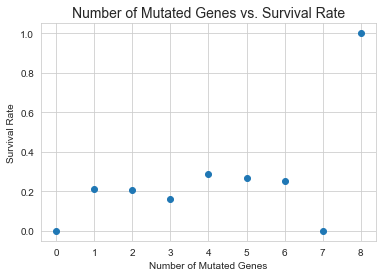

In [3924]:
plt.scatter(df_num_mutated_genes["Number of Mutated Genes"], 
    df_num_mutated_genes["Survival Rate"])
plt.title('Number of Mutated Genes vs. Survival Rate', fontsize=14)
plt.xlabel('Number of Mutated Genes')
plt.ylabel('Survival Rate')
plt.show()

It doesn't appear as though any correlation exists between number of mutated genes and survival rate. As such, number of mutated genes will serve as a poor predictor of cancer outcome and thus this column can be dropped.

In [3925]:
df_data_clinical = df_data_clinical.drop(['Num.Mutated.Genes'], axis=1)

### Age

There doesn't appear to be any obvious correlation between age and prognosis. However, splitting the data into age groups may have yielded a more insightful analysis.

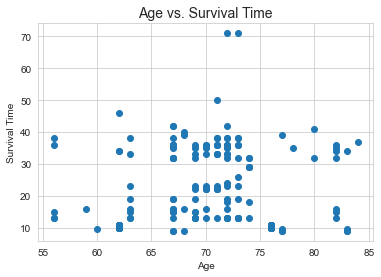

In [3926]:
plt.scatter(df_data_clinical["Age"], df_data_clinical["Survival.Months"])
plt.title('Age vs. Survival Time', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Survival Time')
plt.show()

### Survival/Followup Time

The goal of this investigation is to generate a predictive model of one-year survival after diagnosis with NSCLC (12-month followup time). Before this can be accomplished, it is important to establish an understanding of the distribution of patient outcomes over a wide range of followup times.

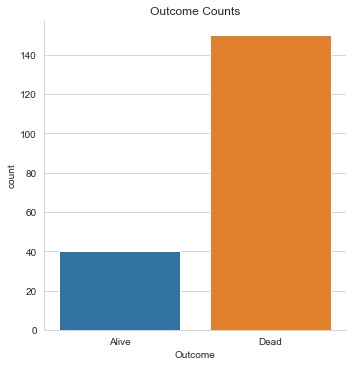

In [3927]:
sns.set_style('whitegrid')
p = sns.catplot(
    x='Outcome', kind='count',
    data=df_data_clinical,
).set(title='Outcome Counts')

In [3928]:
df_followup = df_data_clinical[['Outcome', 'Survival.Months']]

num_alive = len(df_followup[df_followup['Outcome'] == 'Alive'])
num_deceased = len(df_followup[df_followup['Outcome'] == 'Dead'])

print('Number of living patients:', num_alive)
print('Number of deceased patients:', num_deceased)

Number of living patients: 40
Number of deceased patients: 150


Investigating the distribution of survival times:

[Text(0.5, 0, 'Months Survived')]

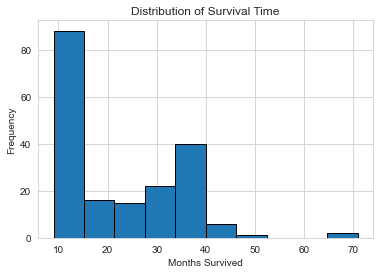

In [3929]:
ax = df_data_clinical['Survival.Months'].plot(kind='hist', edgecolor='black')
ax.set(title='Distribution of Survival Time')
ax.set(xlabel='Months Survived')

In [3930]:
df_data_clinical['Survival.Months'].value_counts()

11.0    27
10.0    23
13.0    21
36.0    18
32.0    11
38.0     9
33.0     8
16.0     8
9.0      7
22.0     7
15.0     7
35.0     6
23.0     6
19.0     6
34.0     4
29.0     3
9.5      3
42.0     3
71.0     2
18.0     2
39.0     2
40.0     1
37.0     1
41.0     1
46.0     1
50.0     1
26.0     1
24.0     1
Name: Survival.Months, dtype: int64

After taking a closer look at patient followup times, it appears as though not many patients followed up at precisely 12 months, but rather within a 10-13 month range. Thus, it may be beneficial to predict one-year survival within a four month range, that is to say predict patient outcomes after between 10 and 14 months after diagnosis rather than at exactly 12 months.

### Effect of Radiation Treatment on Cancer Outcome

The presence or lack of radiation therapy appears to be highly correlated with number of primary tumors, which is in turn highly correlated with survival months. However, further analysis is needed in order to determine if the relationship between radiation therapy and outcome is correlational or causational. It is important to note that patients who underwent radiation therapy likely suffered from more severe or advanced cancers and thus are already more likely to die of their disease. For this reason, radiation therapy alone cannot predict survival, but may be an important feature to include in the model.

In [3931]:
# patients who did and did not receive radiation therapy
patients_w_radiation = df_data_clinical[df_data_clinical['Radiation'] == 5]
patients_wo_radiation = df_data_clinical[df_data_clinical['Radiation'] == 0]

# patients who survived with and without radiation therapy
alive_w_radiation = patients_w_radiation[patients_w_radiation['Outcome'] == 'Alive']
alive_wo_radiation = patients_wo_radiation[patients_wo_radiation['Outcome'] == 'Alive']

# survival rate with and without radiation therapy
rate_w_radiation = len(alive_w_radiation) / len(patients_w_radiation)
rate_wo_radiation = len(alive_wo_radiation) / len(patients_wo_radiation)

print('Survival rate with radiation:', rate_w_radiation)
print('Survival rate without radiation:', rate_wo_radiation)

Survival rate with radiation: 0.2698412698412698
Survival rate without radiation: 0.18110236220472442


Without consideration of the time elapsed after diagnosis before radiation therapy was administered, it appears as though radiation therapy is correlated with more positive outcomes, as the survival rate with radiation is slightly higher at 26.98% compared to the 18.11% survival rate without radiation therapy.

### TNM System

According to the National Cancer Institute, **stage** refers to the extent of a cancer, including factors such as tumor size and whether or not it has spread.

The most commonly used cancer staging system is the TNM Staging System, in which the overall stage of a cancer is determined by rankings assigned to the following descriptors:
- **T:** The size and extent of the primary tumor.
- **N:** The number of nearby lymph nodes to which the cancer has spread.
- **M:** Whether or not the cancer has **metastasized**, or spread from the primary tumor to other parts of the body.

The **T** descriptor can be assigned one of four rankings: either T1, T2, T3, or T4, with 1 representing the smallest primary tumor size and 4 representing the largest tumor size. These rankings can be further divided via the assignment of letters such as T1a and T1b to provide addition decriptive detail. For the sake of converting to a numeric scale, the original ranking system can be simplified into solely numeric rankings of 1, 2, 3, or 4 during preprocessing. The "UNK" ranking may also be converted to "NaN" and imputed with the mean of the dataset as was done during the data cleansing step for the **M** and **N** columns.

In [3932]:
df_data_clinical['T'].value_counts()

UNK    62
3      38
1a     26
4      23
2a     16
2      12
2b     10
1b      2
1       1
Name: T, dtype: int64

The **N** descriptor can be assigned one of three rankings: either N0, N1, N2, or N3 in order to represent the size, location, or number of nearby lymph nodes affected by the cancer. 0 represents the smallest degree of spread to nearby lymph nodes while 3 represents the greatest degree of spread to nearby lymmph nodes. Each **N** value in the dataset should now be rounded to the nearest whole number to compensate for the mean values inserted during imputing.

In [3933]:
df_data_clinical['N'].value_counts()

1.144    65
2.000    58
0.000    52
1.000     9
3.000     6
Name: N, dtype: int64

In [3934]:
df_data_clinical['N'] = df_data_clinical['N'].round(decimals = 0)

In [3935]:
df_data_clinical['N'].value_counts()

1.0    74
2.0    58
0.0    52
3.0     6
Name: N, dtype: int64

The **M** descriptor can be assigned a value of either M0, meaning that the cancer has not metastasized, or M1, meaning that the cancer has metastasized. As in the **N** column, each **M** value should now be rounded to the nearest whole number to compensate for the insertion of mean values during the data cleansing stage. In this dataset, it appears as though most patients' cancers were not metastatic. That is to say, most of the data in this dataset is representative of primary tumors rather than cancer that has spread to other parts of the patients' bodies.

In [3936]:
df_data_clinical['M'].value_counts()

0.085106    96
0.000000    86
1.000000     8
Name: M, dtype: int64

In [3937]:
df_data_clinical['M'] = df_data_clinical['M'].round(decimals = 0)

In [3938]:
df_data_clinical['M'].value_counts()

0.0    182
1.0      8
Name: M, dtype: int64

While the sample size of patients whose cancers are metastatic and/or have spread to nearby lymph nodes to the highest degree are relatively low, it is likely that such cancers will result in negative outcomes due to their severity. Indeed, patients with cancers classified as N3 had a 33% survival rate while patients with metastatic cancers had only a 25% survival rate.

In [3939]:
# patients with cancers that have spread to the greatest degree
patients_spread_to_lymph = df_data_clinical[df_data_clinical['N'] == 3.0]
patients_metastatic = df_data_clinical[df_data_clinical['M'] == 1.0]

# patients who survived such cancers
alive_lymph = patients_spread_to_lymph[patients_spread_to_lymph['Outcome'] == 'Alive']
alive_metastatic = patients_metastatic[patients_metastatic['Outcome'] == 'Alive']

# survival rates 
rate_lymph = len(alive_lymph) / len(patients_spread_to_lymph)
rate_metastatic = len(alive_metastatic) / len(patients_metastatic)

print('Survival rate of patients with N3 cancer:', rate_lymph)
print('Survival rate of patients with metastatic cancer:', rate_metastatic)

Survival rate of patients with N3 cancer: 0.3333333333333333
Survival rate of patients with metastatic cancer: 0.25


### Tumor Primary Site

In [3940]:
df_data_clinical['Primary.Site'].value_counts()

Right Upper Lobe     55
Right Hilar          33
Left Hilar           31
Right Lower Lobe     25
Left Upper Lobe      21
Left Lower Lobe      17
Both Lung             5
Right Middle Lobe     3
Name: Primary.Site, dtype: int64

As in the case of patients with metastatic cancer, it is likely that patients with cancer present in both lungs will have poor prognosis. Indeed, out of the 5 patients with cancer present in both lungs, all died of their illness. Amongst patients with cancer present in only one lung, there is a 21.62% survival rate.

In [3941]:
# patients with cancer in both lungs or in only one lung
patients_both_lungs = df_data_clinical[df_data_clinical['Primary.Site'] == 'Both Lung']
patients_one_lung = df_data_clinical[df_data_clinical['Primary.Site'] != 'Both Lung']

# patients who survived their cancer
alive_both_lungs = patients_both_lungs[patients_both_lungs['Outcome'] == 'Alive']
alive_one_lung = patients_one_lung[patients_one_lung['Outcome'] == 'Alive']

# survival rates
rate_both_lungs = len(alive_both_lungs) / len(patients_both_lungs)
rate_one_lung = len(alive_one_lung) / len(patients_one_lung)

print('Survival rate of patients with cancer present in both lungs:', rate_both_lungs)
print('Survival rate of patients with cancer present in only one lung:', rate_one_lung)

Survival rate of patients with cancer present in both lungs: 0.0
Survival rate of patients with cancer present in only one lung: 0.21621621621621623


### Histological Findings

The histological features are categorical and may help predict cancer outcome.

In [3942]:
df_data_clinical['Histology'].value_counts()

Adenocarcinoma             86
Squamous cell carcinoma    77
Large-cell carcinoma       27
Name: Histology, dtype: int64

## Genomic Data Analysis

In [3943]:
df_data_genomic_raw.head()

,ID,Gene
0,1,AKT1
1,158,AKT1
2,88,ALK_Col1
3,132,ALK_Col1
4,18,ALK_Col2


In [3944]:
df_data_genomic_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      510 non-null    int64 
 1   Gene    510 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.1+ KB


Take a look at one patient:

In [3945]:
df_data_genomic_raw[df_data_genomic_raw['ID'] == 1]

,ID,Gene
0,1,AKT1
31,1,CCND2
85,1,EGFR
107,1,FGFR3
121,1,KRAS_Col1
260,1,PDGFRB
321,1,STK11
479,1,TSC2


In [3946]:
df_data_genomic_raw['Gene'].unique()

array(['AKT1', 'ALK_Col1', 'ALK_Col2', 'APC', 'ATM_Col1', 'ATM_Col2',
       'BRAF', 'CCND2', 'CDKN2A', 'CTNNB1', 'DNMT3A', 'EGFR', 'ERBB3',
       'ERBB4', 'ESR1', 'FBXW7', 'FGFR1', 'FGFR3', 'FLT4', 'FOXL2',
       'GNAS', 'HNF1A', 'KRAS_Col1', 'KRAS_Col2', 'MAP2K2', 'MET',
       'MLH_Col2', 'MSH2', 'MSH6', 'NF_Col1', 'NF_Col2', 'NF_Col3',
       'NF_Col5', 'NOTCH1', 'NTRK1', 'PDGFRB', 'PIK3CA', 'PIK3CB',
       'POLD_Col2', 'PTCH1', 'PTEN', 'RB1', 'SMARCA4', 'SMARCB1', 'SMO',
       'STK11', 'TERT', 'TP53_Col1', 'TP53_Col2', 'TSC2'], dtype=object)

In [3947]:
df_data_genomic_raw['Gene'].value_counts()

TP53_Col1    117
KRAS_Col1     55
CDKN2A        45
TSC2          31
MSH2          30
STK11         23
APC           19
PIK3CB        11
TERT          10
NF_Col2       10
SMARCB1        9
MET            9
TP53_Col2      8
FBXW7          8
SMO            8
NF_Col3        7
GNAS           7
PIK3CA         7
MSH6           7
NTRK1          7
PTEN           7
EGFR           6
POLD_Col2      5
NF_Col1        5
PDGFRB         5
RB1            4
ATM_Col1       4
PTCH1          4
CTNNB1         4
FGFR1          4
NOTCH1         4
DNMT3A         3
CCND2          2
ALK_Col2       2
AKT1           2
NF_Col5        2
ERBB4          2
ALK_Col1       2
FOXL2          2
FLT4           2
FGFR3          2
MLH_Col2       1
MAP2K2         1
KRAS_Col2      1
HNF1A          1
SMARCA4        1
BRAF           1
ATM_Col2       1
ESR1           1
ERBB3          1
Name: Gene, dtype: int64

Immediately, **TP53_Col1** stands out as the most frequently observed mutated gene. **KRAS_Col1** and **CDKN2A** also stand out as two potential at-risk genes. Additional background on each of these genes is provided below.

### TP53 (Tumor Protein P53)
>TP53 encodes instructions for making the tumor suppressor protein p53, which regulates cell division by preventing cells from growing and proliferating in an uncontrolled manner. Somatic mutations in the TP53 gene are one of the most frequently observed mutations in human cancers. Furthermore, germline mutations of TP53 provide the hereditary basis for Li-Fraumeni syndrome (LFS). People with LFS are predisposed to a broad variety of early-onset cancers.

### KRAS (K-Ras)
>KRAS provides instructions for the production of the protein K-Ras, which plays an important role in the RAS/MAPK signalling pathway. The function of this pathway is to transduce extracellular signals to the cell's nucleus, where specific genes are activated for cell growth, division, and differentiation.

### CDKN2A (Cyclin-Dependent Kinase Inhibitor 2A)
>CDKN2A is ubiquitously expressed in many human tissues and codes for several proteins, the most well-studied of which being the p16(INK4A) and the p14(ARF) proteins. Notably, the ARF product functions as a stabilizer of the tumor suppressor protein p53.

### Effects of Mutations in TP53, KRAS, and CDKN2A on Prognosis

Merging the clinical data dataframe and the genomic data dataframe results in an inefficiently organized table in which each distinct patient ID appears in multiple rows, with the only distinction between each row being a different mutated gene. This results in a lot of data redundancy which could be eliminated by creating a gene matrix in which each gene occupies its own column, with each row representing a distinct patient ID. However, this merged dataframe can be useful for quickly retrieving clinical information that may be correlated with the three at-risk genes of interest: **TP53**, **KRAS**, and **CDKN2A**.

In [3948]:
df_clinical_genes = pd.merge(df_data_clinical, df_data_genomic_raw)
df_clinical_genes

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Gene
0,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,AKT1
1,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,CCND2
2,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,EGFR
3,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,FGFR3
4,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000,KRAS_Col1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,189,Dead,32.0,67,1,1a,1.0,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.000000,CDKN2A
506,189,Dead,32.0,67,1,1a,1.0,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.000000,FBXW7
507,189,Dead,32.0,67,1,1a,1.0,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.000000,TP53_Col1
508,190,Dead,33.0,71,0,2a,1.0,0.0,0,IIIB,Right Upper Lobe,Adenocarcinoma,4.494898,CDKN2A


Function for querying the merged dataframe by gene:

In [3949]:
def query_by_gene(dataframe, gene):
    return dataframe[dataframe['Gene']==gene]

In [3950]:
query_by_gene(df_clinical_genes, 'TP53_Col1')

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Gene
9,2,Dead,19.0,73,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,4.494898,TP53_Col1
14,4,Dead,15.0,69,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,4.494898,TP53_Col1
16,5,Dead,10.0,76,0,UNK,1.0,0.0,0,IIIA,Left Hilar,Large-cell carcinoma,4.494898,TP53_Col1
20,6,Dead,11.0,62,0,3,2.0,0.0,0,IVB,Left Hilar,Adenocarcinoma,4.494898,TP53_Col1
25,7,Dead,13.0,72,0,4,1.0,1.0,5,IV,Right Hilar,Adenocarcinoma,5.500000,TP53_Col1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,183,Dead,35.0,72,1,UNK,2.0,0.0,0,IIA,Right Lower Lobe,Squamous cell carcinoma,2.000000,TP53_Col1
496,185,Alive,33.0,71,0,UNK,0.0,0.0,0,IV,Right Lower Lobe,Adenocarcinoma,1.500000,TP53_Col1
504,188,Dead,23.0,72,0,3,1.0,0.0,0,IA,Right Upper Lobe,Squamous cell carcinoma,2.000000,TP53_Col1
507,189,Dead,32.0,67,1,1a,1.0,0.0,0,IV,Right Upper Lobe,Adenocarcinoma,10.000000,TP53_Col1


In [3951]:
# clinical data for patients with mutations in either TP53, KRAS, or CDKN2A
patients_tp53 = query_by_gene(df_clinical_genes, 'TP53_Col1')
patients_kras = query_by_gene(df_clinical_genes, 'KRAS_Col1')
patients_cdkn2a = query_by_gene(df_clinical_genes, 'CDKN2A')

# patients with each mutated gene that survived their cancer
alive_tp53 = patients_tp53[patients_tp53['Outcome'] == 'Alive']
alive_kras = patients_kras[patients_kras['Outcome'] == 'Alive']
alive_cdkn2a = patients_cdkn2a[patients_cdkn2a['Outcome'] == 'Alive']

# survival rate
rate_tp53 = len(alive_tp53) / len(patients_tp53)
rate_kras = len(alive_kras) / len(patients_kras)
rate_cdkn2a = len(alive_cdkn2a) / len(patients_cdkn2a)

print('Survival rate of patients with TP53 mutation(s):', rate_tp53)
print('Total number of patients with TP53 mutation(s):', len(patients_tp53), '\n')
print('Survival rate of patients with KRAS mutation(s):', rate_kras)
print('Total number of patients with KRAS mutation(s):', len(patients_kras), '\n')
print('Survival rate of patients with CDKN2A mutation(s):', rate_cdkn2a)
print('Total number of patients with CDKN2A mutation(s):', len(patients_cdkn2a))

Survival rate of patients with TP53 mutation(s): 0.2564102564102564
Total number of patients with TP53 mutation(s): 117 

Survival rate of patients with KRAS mutation(s): 0.23636363636363636
Total number of patients with KRAS mutation(s): 55 

Survival rate of patients with CDKN2A mutation(s): 0.06666666666666667
Total number of patients with CDKN2A mutation(s): 45


The survival rate for patients with mutation(s) in TP53, KRAS, and CDKN2A are 25.64%, 23.64%, and 6.67%, respectively. While TP53 is the most frequently observed mutated gene, CDKN2A is correlated with poorer prognosis. This suggests that while TP53 may be the most commonly mutated gene in this dataset, other less frequently occuring mutations may exist that have substantially detrimental effects on cancer outcome. Thus, more at-risk genes may be discovered by examining the genomic data of deceased patients.

In [3952]:
genes = df_clinical_genes['Gene'].unique()
num_patients = []
rates = []

for gene in genes:
    df_genes = df_clinical_genes[df_clinical_genes['Gene'] == gene]
    alive_patients = len(df_genes[df_genes['Outcome'] == 'Alive'])
    total_patients = len(df_genes)
    rate = num_alive / total_patients

    num_patients.append(total_patients)
    rates.append(rate)

gene_dictionary = {"Gene":genes, "Number of Patients":num_patients, "Survival Rate":rates}
df_gene_survival = pd.DataFrame(gene_dictionary)

In [3953]:
df_gene_survival.head()

,Gene,Number of Patients,Survival Rate
0,AKT1,2,20.000000
1,CCND2,2,20.000000
2,EGFR,6,6.666667
3,FGFR3,2,20.000000
4,KRAS_Col1,55,0.727273


In [3954]:
df_gene_survival.sort_values(by='Survival Rate')

,Gene,Number of Patients,Survival Rate
9,TP53_Col1,117,0.341880
4,KRAS_Col1,55,0.727273
10,CDKN2A,45,0.888889
7,TSC2,31,1.290323
14,MSH2,30,1.333333
6,STK11,23,1.739130
13,APC,19,2.105263
12,PIK3CB,11,3.636364
17,TERT,10,4.000000
34,NF_Col2,10,4.000000


In addition to TP53, KRAS, and CDKN2A, three additional potential at-risk genes are TSC2, MSH2, and STK11 due to their low survival rates. However, mutations in TP53, KRAS, and CDKN2A remain the most important genetic prognostic features due to the combination of their prevalence and severity of outcome.

## Summary of Important Prognostic Factors

After performing exploratory data analysis, the most important prognostic factors from the clinical data were determined to be:
- Number of primary tumors
- Exposure to radiation treatments
- Tumor stage (including TNK System)
- Tumor location
- Histological findings

The most important prognostic factors from the genomic data were determined to be the presence of variants for the following genes:
- TP53
- CDKN2A
- KRAS

Together, these features can be used to train a random forest classification algorithm in order to predict one-year survival after diagnosis with NSCLC.

## Data Preprocessing

In [3955]:
data = df_data_clinical.copy()
data.head()

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size
0,1,Alive,9.0,67,0,UNK,2.0,0.0,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.400000
1,2,Dead,19.0,73,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,4.494898
2,3,Dead,13.0,72,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.500000
3,4,Dead,15.0,69,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,4.494898
4,5,Dead,10.0,76,0,UNK,1.0,0.0,0,IIIA,Left Hilar,Large-cell carcinoma,4.494898


In [3956]:
data = data.reset_index()
new_T = []
new_stage = []
new_radiation = []
new_primary_site = []
new_outcome = []

for index, row in data.iterrows():

    # T: converting non-null values to integers
    if (row['T'] != 'UNK'):
        new_T.append(int(row['T'][0]))      # remove intermediate classes
    else:
        new_T.append(row['T'])

    # Radiation: converting to Boolean flags
    if (row['Radiation'] == 5):
        new_radiation.append(1)     # exposure to radiation treatment
    else:
        new_radiation.append(0)     # no exposure to radiation treatment

    # Primary Site: converting to Boolean flags
    if (row['Primary.Site'] == 'Both Lung'):
        new_primary_site.append(1)      # flag for high risk
    else:
        new_primary_site.append(0)      # flag for lower risk

    # Stage: converting to numeric values (remove intermediate classes)
    if (row['Stage'] in ['IA','IB','1B']):      # stage 1
        new_stage.append(1)
    elif (row['Stage'] in ['IIA','IIB']):       # stage 2
        new_stage.append(2)
    elif (row['Stage'] in ['IIIA','IIIB']):     # stage 3
        new_stage.append(3)
    elif (row['Stage'] in ['IV','IVB']):        # stage 4
        new_stage.append(4)

    # Outcome: converting to Boolean flags
    if (row['Outcome'] == 'Alive'):
        new_outcome.append(1)       # patient is living
    elif (row['Outcome'] == 'Dead'):
        new_outcome.append(0)       # patient is deceased


In [3957]:
# update data with new cleaned columns
data['T'] = new_T
data['Stage'] = new_stage
data['Both Lungs'] = new_primary_site
data['Radiation'] = new_radiation
data['Tumor.Size'] = data['Tumor.Size'].round()
data['Outcome'] = new_outcome


In [3958]:
# replace the UNK entries in T with the mean
data['T'] = data['T'].replace('UNK', np.nan)
T_mean = data['T'].mean()
T_mean = T_mean.round()
data['T'].fillna(value=T_mean, inplace=True)

In [3959]:
data = data.drop(columns=['index', 'Primary.Site'])
data

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Histology,Tumor.Size,Both Lungs
0,1,1,9.0,67,0,2.0,2.0,0.0,0,4,Squamous cell carcinoma,1.0,0
1,2,0,19.0,73,0,2.0,2.0,0.0,1,4,Adenocarcinoma,4.0,0
2,3,0,13.0,72,0,2.0,2.0,0.0,0,3,Adenocarcinoma,2.0,0
3,4,0,15.0,69,1,1.0,0.0,1.0,0,1,Adenocarcinoma,4.0,0
4,5,0,10.0,76,0,2.0,1.0,0.0,0,3,Large-cell carcinoma,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,186,0,32.0,82,0,4.0,0.0,1.0,0,3,Squamous cell carcinoma,9.0,0
186,187,0,10.0,62,0,3.0,2.0,0.0,0,4,Large-cell carcinoma,4.0,0
187,188,0,23.0,72,0,3.0,1.0,0.0,0,1,Squamous cell carcinoma,2.0,0
188,189,0,32.0,67,1,1.0,1.0,0.0,0,4,Adenocarcinoma,10.0,0


In [3960]:
# divide histological findings into three separate columns
onehot_hist = pd.get_dummies(data['Histology'])
data = data.drop(columns=['Histology'])
data = data.join(onehot_hist)

data.head()

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Tumor.Size,Both Lungs,Adenocarcinoma,Large-cell carcinoma,Squamous cell carcinoma
0,1,1,9.0,67,0,2.0,2.0,0.0,0,4,1.0,0,0,0,1
1,2,0,19.0,73,0,2.0,2.0,0.0,1,4,4.0,0,1,0,0
2,3,0,13.0,72,0,2.0,2.0,0.0,0,3,2.0,0,1,0,0
3,4,0,15.0,69,1,1.0,0.0,1.0,0,1,4.0,0,1,0,0
4,5,0,10.0,76,0,2.0,1.0,0.0,0,3,4.0,0,0,1,0


In [3961]:
# at risk genes
TP53_Col1 = []
KRAS_Col1 = []
CDKN2A = []

gene_list = [TP53_Col1, KRAS_Col1, CDKN2A]
gene_string_list = ['TP53_Col1', 'KRAS_Col1', 'CDKN2A']

for index2, row2 in data.iterrows():
    for gene, gene_string in zip(gene_list, gene_string_list):
        df_at_risk_genes = df_data_genomic_raw[df_data_genomic_raw['Gene'] == gene_string]

        # add Boolean flags for the presence of specific at-risk genes
        if (row2['ID'] in df_at_risk_genes['ID'].values):
            gene.append(1)      # gene variant is present
        else:
            gene.append(0)      # gene variant is not present

In [3962]:
# add the new gene variant columns to the dataframe
for col_name, col in zip(gene_string_list, gene_list):
    data[col_name] = col

### Final Cleaned Data

In [3963]:
data.head()

,ID,Outcome,Survival.Months,Age,Num.Primaries,T,N,M,Radiation,Stage,Tumor.Size,Both Lungs,Adenocarcinoma,Large-cell carcinoma,Squamous cell carcinoma,TP53_Col1,KRAS_Col1,CDKN2A
0,1,1,9.0,67,0,2.0,2.0,0.0,0,4,1.0,0,0,0,1,0,1,0
1,2,0,19.0,73,0,2.0,2.0,0.0,1,4,4.0,0,1,0,0,1,0,0
2,3,0,13.0,72,0,2.0,2.0,0.0,0,3,2.0,0,1,0,0,0,0,0
3,4,0,15.0,69,1,1.0,0.0,1.0,0,1,4.0,0,1,0,0,1,0,1
4,5,0,10.0,76,0,2.0,1.0,0.0,0,3,4.0,0,0,1,0,1,1,0


## Building the Model

Because this model is tasked with predicting a discrete value after a given time step (alive or deceased), a classification algorithm is best suited for this task. **Classification** is broadly defined as a problem of identifying which set of categories a new observation belongs to. Thus, the model can help predict, given clinical and genomic data, which outcome class a patient might belong to after a 12-month period. 

One of many classification techniques, **random forest** classification algorithms are generally well suited for big data classification. Random forest classification works via the operation of a large ensemble of individual diceision trees. After each individual decision tree in the forest produces a class prediction, the class with the most votes forms the overall model's prediction. Compared to a simple decision tree, random forest classification algorithms avoid and prevent overfitting through this usage of multiple trees.

This implementation of random forest classification uses the `sklearn.RandomForestClassifer`. Random forest classification was chosen as the ideal classification algorithm with which to build this model due to the ease of hyperparamater tuning and its ability to avoid overfitting. Additionally, a quick literature seach revealed that random forest classification is commonly used for similar modeling tasks of predicting cancer outcomes from genomic and/or clinical data.

In [3964]:
X = data.drop(columns=['ID', 'Outcome'])
X.shape

(190, 16)

In [3965]:
y = data.loc[:, 'Outcome']
y.shape

(190,)

After hyperparameter tuning, the ideal `test_size` was determined to be 0.20 and the ideal `n_estimators` was determined to be 100. While lower numbers of estimators were initially tested to avoid issues of overfitting, K Folds cross-validation confirmed minimal changes in mean absolute error resulted from increasing the number of estimators from 10 to 100. Similarly, a conventional 80/20 train/test split was determined to yield the highest accuracy at minimal cost to mean absolute error. The entropy criterion for `RandomForestClassifier()` was selected in the hopes of providing better results. Given the relatively small size of this dataset at 190 rows, the performance cost of using entropy instead of gini is minimal.

In [3966]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [3967]:
model = RandomForestClassifier(n_estimators=100, criterion="entropy")

model.fit(X_train, y_train)
predictions = model.predict(X_test)

## Evaluating the Model

### Overfitting

In contrast to `train_test_split()`, K Folds cross-validation using `Kfold()` can be used to verify whether the model is overfitted. K Folds works by splitting the dataset into **k** subsets, training the model **k** times on different training sets, and testing the model **k** times on different test sets. Mean Aboslute Error (MAE) for the training and test sets can then be calculated in order to determine if the model is overfitted.

In [3968]:
def test_overfitting(X, y):

   kf = KFold(n_splits=4)
   mae_train = []
   mae_test = []
   
   for train_index, test_index in kf.split(X):
    
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y[train_index], y[test_index]
      model = KNeighborsClassifier(n_neighbors=2)
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      y_test_pred = model.predict(X_test)
      mae_train.append(mean_absolute_error(y_train, y_train_pred))
      mae_test.append(mean_absolute_error(y_test, y_test_pred))

   folds = range(1, kf.get_n_splits() + 1)
   plt.plot(folds, mae_train, 'o-', color='green', label='train')
   plt.plot(folds, mae_test, 'o-', color='red', label='test')
   plt.legend()
   plt.grid()
   plt.xlabel('Number of Folds')
   plt.ylabel('Mean Absolute Error')
   plt.show()

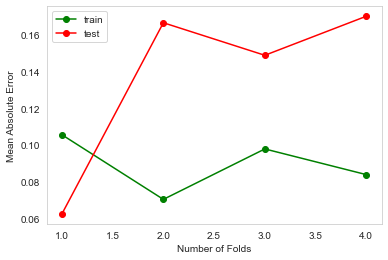

In [3969]:
test_overfitting(X, y)

The testing MAE ranges between 0.6 and 0.18, suggesting that the model is not overfitted.

### Accuracy

In [3970]:
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8947368421052632


In [3971]:
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)

[[32  0]
 [ 4  2]]


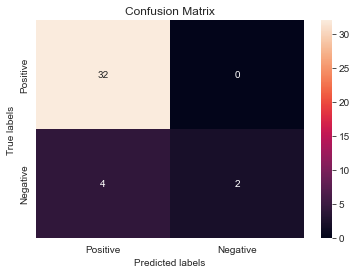

In [3972]:
lables = ['Positive','Negative']

ax = plt.subplot()

sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(lables) 
ax.yaxis.set_ticklabels(lables)

plt.savefig('Figures/confusion_matrix.png')